# Data


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/FERDataset.zip"

In [2]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [3]:
classes = {
    0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'
}

In [4]:
import os
from PIL import Image
import glob
import torch 

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

In [5]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [82]:
class FERDataset(Dataset):

  def load_data(self,base_path, setname):
    images = []
    labels = []
    path = base_path+'/images/'+ setname
    for expression in os.listdir(path):
      for img in os.listdir(path+'/'+ expression):
        images.append(path+'/'+ expression+'/'+img)

        labels.append(get_keys_from_value(classes, expression)[0])
  
    
    return images, labels
  
  def __init__(self, base_path, setname, transforms =None):
    self.images, self.labels = self.load_data(base_path,setname)
    self.transforms = transforms
  
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, index):
    image = Image.open(self.images[index]).convert('RGB')
    label = torch.tensor(self.labels[index])
    image_path = self.images[index]
    if self.transforms is not None:

      image = self.transforms(image)
    
    return image, label, image_path


In [83]:
transforms_train = transforms.Compose([
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))])

transforms_valid = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5), (0.5))])

In [84]:
trainset = FERDataset("/content/images", "train", transforms_train)
validset = FERDataset("/content/images", "validation", transforms_valid)

In [85]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
valid_loader = DataLoader(validset, batch_size=128, shuffle=True)

# Model

In [80]:
epochs = 20

In [72]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Train

In [77]:
model = VGG('VGG19').to(DEVICE)

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision

import numpy as np

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
loss_list = []
val_loss_list = []
accuracy_list = []

In [86]:

for epoch in range(epochs):
  train_loss = 0.0
  val_loss = 0.0
  total = 0

  for i, (image, label, image_path) in enumerate(train_loader):

    image, label = image.to(DEVICE), label.to(DEVICE)

    optimizer.zero_grad()

    output = model(image)
    loss = criterion(output,label)
    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    #total += label.size(0)
    total += 1

  train_loss = train_loss / total
  loss_list.append(train_loss)
  

  correct = 0
  total = 0
  with torch.no_grad():

    for i, (image, label,image_path) in enumerate(valid_loader):
      image, label = image.to(DEVICE), label.to(DEVICE)

      output = model(image)

      loss = criterion(output,label)

      val_loss += loss.item()


      _, predicted = torch.max(output.data, 1)
      correct += predicted.eq(label.data).cpu().sum()
      total +=1 
    val_loss = val_loss/total 
    val_loss_list.append(val_loss)

    accuracy = correct /total
    accuracy_list.append(accuracy.item())
    print("Epoch : ", epoch, " / Train Loss ", train_loss, "/ Val loss ", val_loss, "/ Acc : ", accuracy.item() )











Epoch :  0  / Train Loss  1.8819150159844256 / Val loss  1.8035317276205336 / Acc :  31.60714340209961
Epoch :  1  / Train Loss  1.7418009491093391 / Val loss  1.6845257367406572 / Acc :  39.35714340209961
Epoch :  2  / Train Loss  1.5900091233506668 / Val loss  1.4336504978793008 / Acc :  57.16071319580078
Epoch :  3  / Train Loss  1.3839776041233434 / Val loss  1.3079924849527222 / Acc :  60.94643020629883
Epoch :  4  / Train Loss  1.2818701383286872 / Val loss  1.2269531190395355 / Acc :  66.85713958740234
Epoch :  5  / Train Loss  1.2150179743766785 / Val loss  1.2059386202267237 / Acc :  67.83928680419922
Epoch :  6  / Train Loss  1.1708131556489827 / Val loss  1.1807404139212199 / Acc :  70.10713958740234
Epoch :  7  / Train Loss  1.1278191409279814 / Val loss  1.127629819725241 / Acc :  72.96428680419922
Epoch :  8  / Train Loss  1.1037042286016245 / Val loss  1.09744201281241 / Acc :  73.66071319580078
Epoch :  9  / Train Loss  1.070499762497117 / Val loss  1.1102027563112122 /

In [141]:
torch.save(model.state_dict(), "model.pt")

# Results


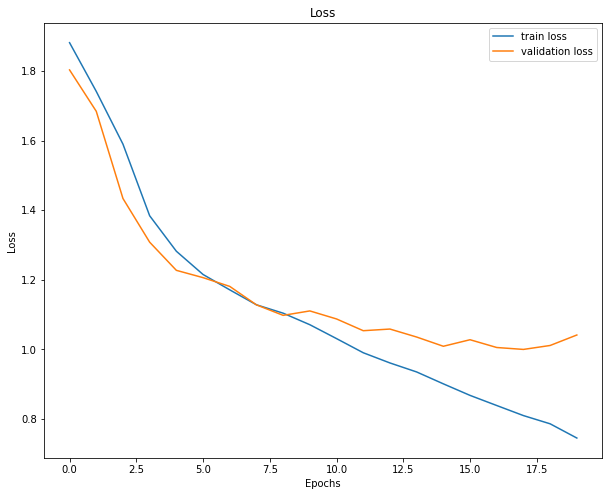

In [88]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize =(10, 8))
plt.plot(loss_list, label="train loss")
plt.plot(val_loss_list, label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss")
plt.legend()
  
# To load the display window
plt.show()

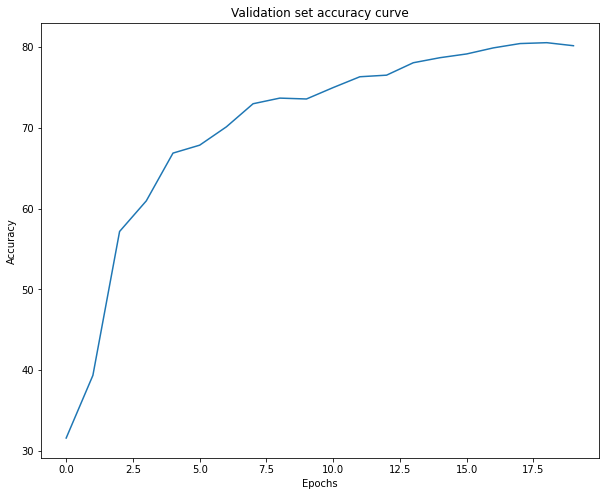

In [89]:
plt.figure(figsize =(10, 8))
plt.plot()
plt.plot(range(len(accuracy_list)), accuracy_list)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation set accuracy curve")

plt.show()

# Test

In [142]:

net =  VGG('VGG19').to(DEVICE)
# CHANGE HERE WITH YOUR MODEL PATH 
net.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [104]:
def check_accuracy(image, label, model):
  model.eval()

  with torch.no_grad():
    image, label = image.to(DEVICE), label.to(DEVICE)
    output = model(image)
    _, predicted = torch.max(output.data, 1)

    return predicted


In [114]:
import random

In [95]:
#LOAD HERE A TEST SET 
validset = FERDataset("/content/images", "validation", transforms_valid)
test_loader = DataLoader(validset, batch_size=64, shuffle=True)

In [100]:
test = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  sad
Correct label:  sad


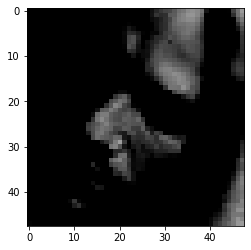

In [147]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  angry
Correct label:  fear


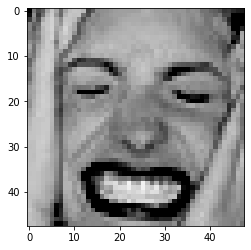

In [146]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  sad
Correct label:  sad


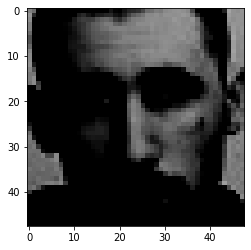

In [145]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  sad
Correct label:  neutral


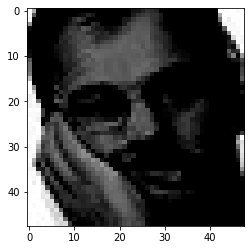

In [143]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  neutral
Correct label:  neutral


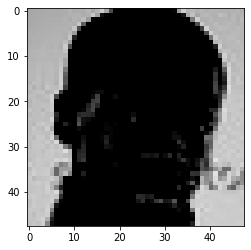

In [148]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  angry
Correct label:  angry


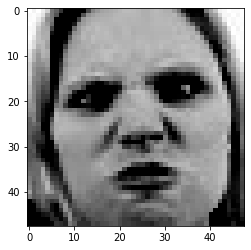

In [149]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  sad
Correct label:  fear


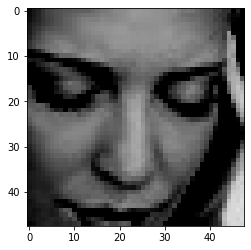

In [150]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label:  angry
Correct label:  angry


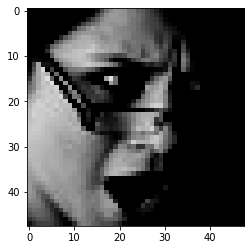

In [151]:
images, labels, path = test.next()
random_idx = random.sample(range(0,5),1)[0] 
image = torch.reshape(images[random_idx],(1,3,48,48))
predicted_idx = check_accuracy(image,labels[random_idx],net)
print("Predicted label: ",classes[predicted_idx.item()]) 
print("Correct label: ",classes[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
image = torch.reshape(image,(3,48,48))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  